# Import

In [20]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
from get_dataset import get_training_and_validation
from tensorflow.keras.models import save_model, load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import save_model, load_model

In [21]:
#import tensorflow as tf
#print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#tf.debugging.set_log_device_placement(True)

In [43]:
batch_size = 16
epochs = 50
IMG_HEIGHT = 256
IMG_WIDTH = 256


# make sure to write own classifier-function in next cell
# if num_classes is greater than 2

# Load Data

In [44]:
# this filter allows all combination with exactly 1 human on it
# artificial masks (photoshop, cg), are not distinguished

# this implicite sets the ['class'] as follows:
#   with_mask >= 1 -> 'mask'
#   with_mask == 0 -> 'no_mask'
#  classifier-attribute can be set to own function for matching data-rows into classes
frame = get_training_and_validation(people_per_img = 1, with_mask=None, no_mask=None, unknown=0,validation_split=0.15 ,test_split=0.1)

train_frame=frame[0]
val_frame=frame[1]
test_frame=frame[2]


print('Filter returned {:d} train images'.format(len(train_frame)))
print(Counter(train_frame['class']))
print('Filter returned {:d} valid images'.format(len(val_frame)))
try:
    print('Filter returned {:d} test images'.format(len(test_frame)))
except:
    print ("Filter returned no test images")
    
num_classes = len(Counter(train_frame['class']))

Filter returned 6867 train images
Counter({'no_mask': 5381, 'mask': 1486})
Filter returned 1373 valid images
Filter returned 915 test images


# Data preparation

In [45]:
def get_data_generator(image_generator, frame, color_mode="rgb",shuffle=True):
    return image_generator.flow_from_dataframe(frame, directory='./', x_col='Path', y_col='class', color_mode=color_mode,
                                                 batch_size = batch_size, shuffle=shuffle, target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='categorical')

In [46]:
# generator for all data
image_generator = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=15,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.2
                    )
image_generator_test = ImageDataGenerator(rescale=1./255)

In [47]:
train_data_gen = get_data_generator(image_generator, train_frame)

validation_data_gen = get_data_generator(image_generator_test, val_frame)


Found 6855 validated image filenames belonging to 2 classes.
Found 1373 validated image filenames belonging to 2 classes.


C:\Users\Daniel\.conda\envs\Tensorflow\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 12 invalid image filename(s) in x_col="Path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [48]:
sample_training_images, _ = next(train_data_gen)

In [49]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img,interpolation='none')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

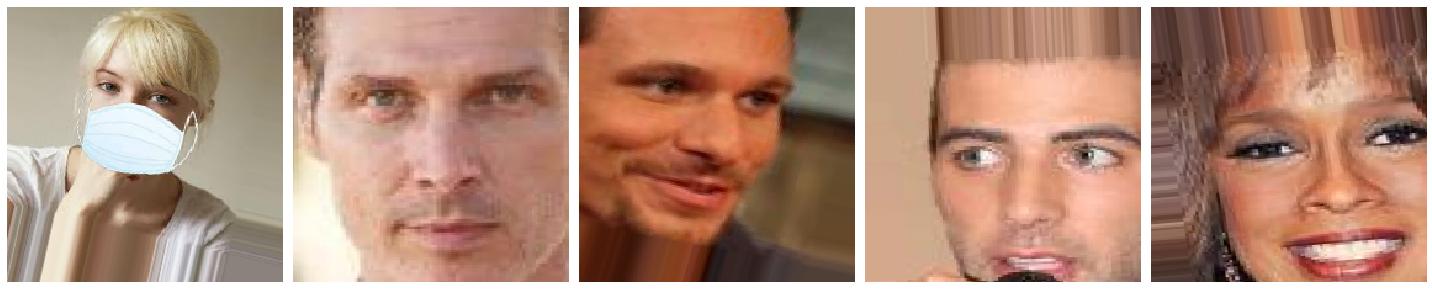

In [50]:
plotImages(sample_training_images[:5])

# Display Functions

In [51]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [52]:
def plot_reports(used_model, test_data_gen):

    Y_pred = used_model.predict(test_data_gen)
    predict_class = np.argmax(Y_pred, axis=1)
    predict_class = predict_class.tolist()


    #print('Confusion Matrix')
    #print(confusion_matrix(test_data_gen.classes, predict_class))
    print('Classification Report')
    target_names = ['Mask','NoMask']
    print(classification_report(test_data_gen.classes, predict_class, target_names=target_names))

    print('Confusion Matrix')
    matrix=confusion_matrix(test_data_gen.classes,predict_class)
    confusion_matrix_plot=ConfusionMatrixDisplay(matrix, display_labels=target_names).plot()

# First Model
## Create a starting model

In [32]:
model = Sequential([
    Conv2D(32, 3, padding='same', strides=2,activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', strides=2,activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', strides=2,activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [33]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

## Train the model

In [17]:
#small training with only X epochs - save old epochs value
epochs_saved=epochs
epochs=1
history = model.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=validation_data_gen,
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 429 steps, validate for 86 steps
429/429 [==============================] - 121s 283ms/step - loss: 0.2284 - accuracy: 0.9142 - val_loss: 0.1360 - val_accuracy: 0.9555


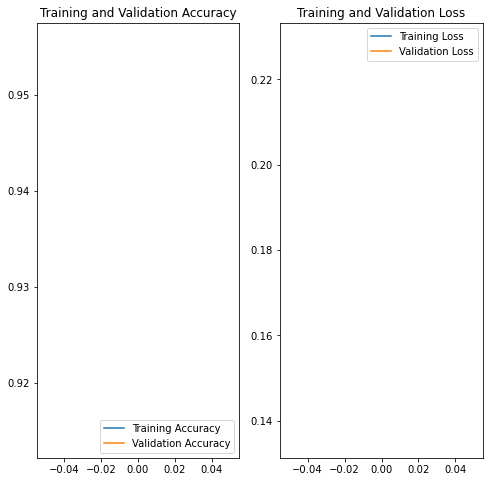

Classification Report
              precision    recall  f1-score   support

        Mask       0.25      0.22      0.24       287
      NoMask       0.80      0.82      0.81      1083

    accuracy                           0.70      1370
   macro avg       0.53      0.52      0.52      1370
weighted avg       0.69      0.70      0.69      1370

Confusion Matrix


AttributeError: 'ConfusionMatrixDisplay' object has no attribute 'show'

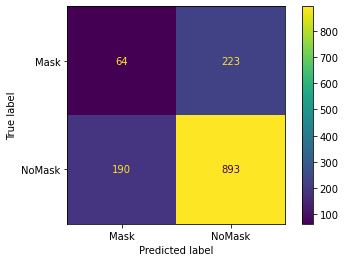

In [24]:
plot_history(history)
plot_reports(model, validation_data_gen)

In [19]:
#RESTORE old epochs value
epochs=epochs_saved

# Data augmentation versions

## Flip and Shift

In [25]:
#Flip and shift by up to 15%
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True,width_shift_range=.15,
                    height_shift_range=.15,)

train_data_gen = get_data_generator(image_gen, train_frame)

Found 6857 validated image filenames belonging to 2 classes.


C:\Users\Daniel\.conda\envs\Tensorflow\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 10 invalid image filename(s) in x_col="Path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


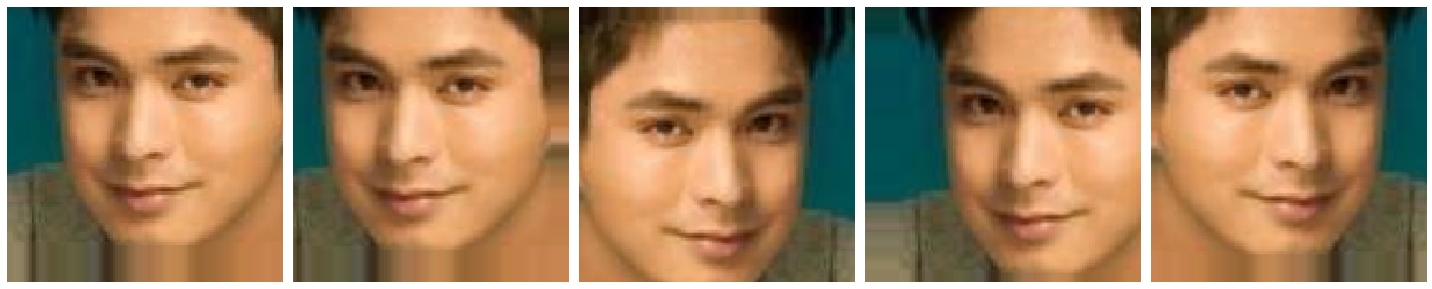

In [26]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

## Rotate

In [27]:
# Rotate picture by -15 to 15 degree
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=15)

train_data_gen = get_data_generator(image_gen, train_frame)

Found 6857 validated image filenames belonging to 2 classes.


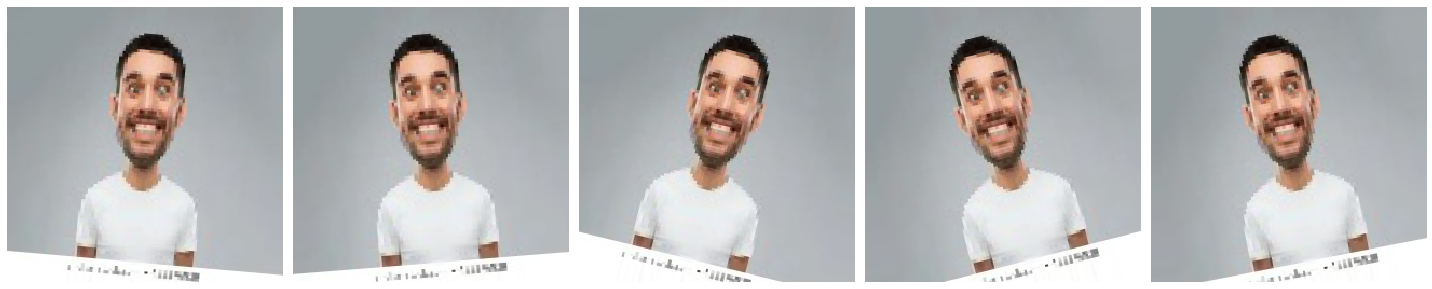

In [28]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

## Zoom

In [29]:
# Zoom picture up to 30%
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.3)

train_data_gen = get_data_generator(image_gen, train_frame)

Found 6857 validated image filenames belonging to 2 classes.


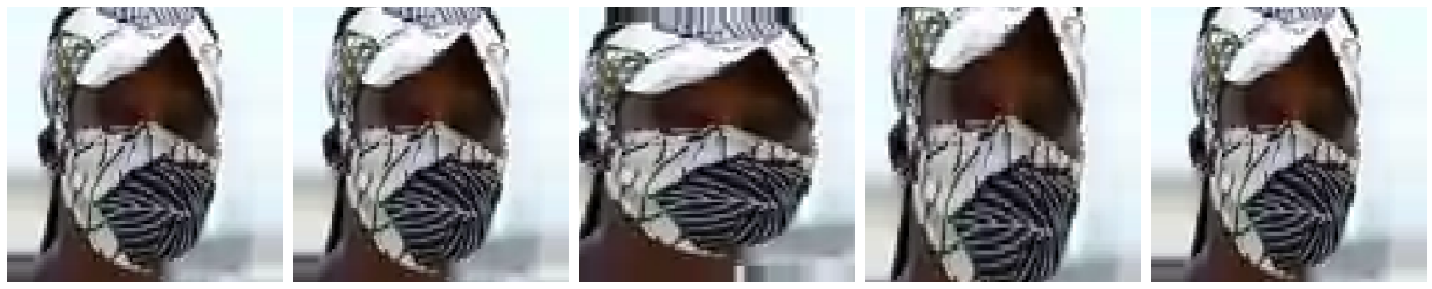

In [30]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

# Updated Image Generator

In [53]:
# generator for all data
image_generator = ImageDataGenerator(
                    #zca_whitening=True
                    #featurewise_center=True,
                    #featurewise_std_normalization=True,
                    rescale=1./255,
                    rotation_range=10,
                    width_shift_range=.10,
                    height_shift_range=.10,
                    horizontal_flip=True,
                    zoom_range=0.2,
                    shear_range=10,
                    channel_shift_range=10,
                    brightness_range=(0.7,1.5),
                    fill_mode="nearest",
                    )

#image generator for test data
image_generator_test = ImageDataGenerator(rescale=1./255,fill_mode="constant",)

In [54]:
train_data_gen = get_data_generator(image_generator, train_frame)

validation_data_gen = get_data_generator(image_generator_test, val_frame)

test_data_gen = get_data_generator(image_generator_test, test_frame, shuffle=False)

Found 6855 validated image filenames belonging to 2 classes.
Found 1373 validated image filenames belonging to 2 classes.
Found 914 validated image filenames belonging to 2 classes.


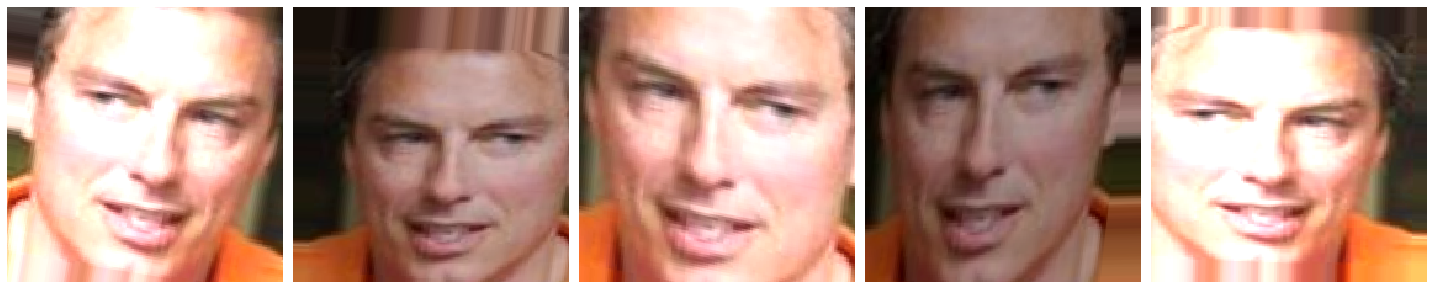

In [55]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)


# Second Model with Dropout

In [40]:
model_2 = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', strides=4, activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(128, 3, padding='same', strides=2, activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

In [41]:
model_2.compile( optimizer='adam', #optimizer='rmsprop',
                  loss='binary_crossentropy',#tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
 
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 4, 128)        

## Train the Model

In [42]:
checkpoint_filepath = './tmp/model_checkpoint'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, verbose=1,
                              cooldown=0, mode='auto',min_delta=0.0001, min_lr=0)

In [309]:
history_2 = model_2.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=validation_data_gen,
    callbacks=[model_checkpoint_callback,earlyStopping,reduce_lr]
)
model_2.load_weights(checkpoint_filepath)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 429 steps, validate for 86 steps
Epoch 1/50


C:\Users\Daniel\.conda\envs\Tensorflow\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Daniel\.conda\envs\Tensorflow\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


429/429 [==============================] - 153s 356ms/step - loss: 0.2861 - accuracy: 0.8858 - val_loss: 0.1579 - val_accuracy: 0.9401
Epoch 2/50
429/429 [==============================] - 147s 343ms/step - loss: 0.1932 - accuracy: 0.9242 - val_loss: 0.1346 - val_accuracy: 0.9496
Epoch 3/50
429/429 [==============================] - 145s 338ms/step - loss: 0.1797 - accuracy: 0.9306 - val_loss: 0.1432 - val_accuracy: 0.9481
Epoch 4/50
429/429 [==============================] - 144s 337ms/step - loss: 0.1580 - accuracy: 0.9370 - val_loss: 0.1357 - val_accuracy: 0.9459
Epoch 5/50
429/429 [==============================] - 144s 337ms/step - loss: 0.1478 - accuracy: 0.9446 - val_loss: 0.1179 - val_accuracy: 0.9525
Epoch 6/50
429/429 [==============================] - 145s 338ms/step - loss: 0.1398 - accuracy: 0.9460 - val_loss: 0.1421 - val_accuracy: 0.9503
Epoch 7/50
429/429 [==============================] - 144s 337ms/step - loss: 0.1465 - accuracy: 0.9434 - val_loss: 0.1506 - val_accura

Epoch 00047: early stopping


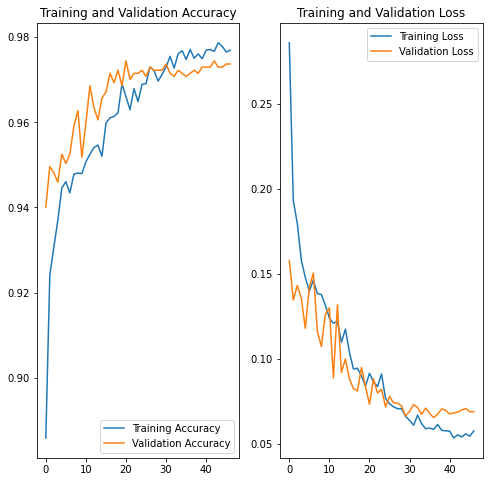

In [310]:
plot_history(history_2)


## Test

Classification Report
              precision    recall  f1-score   support

        Mask       0.95      0.89      0.92       204
      NoMask       0.97      0.99      0.98       711

    accuracy                           0.97       915
   macro avg       0.96      0.94      0.95       915
weighted avg       0.97      0.97      0.97       915

Confusion Matrix


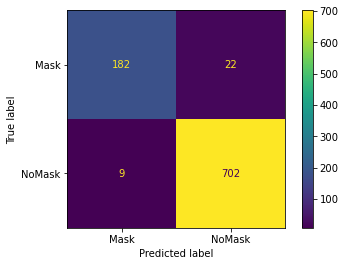

In [311]:
plot_reports(model_2, test_data_gen)

In [312]:
model_2.save('saved_models/model_2')
#used_model.save('saved_model_test')

INFO:tensorflow:Assets written to: saved_models/model_2\assets


# Try out different models
## Create models

In [34]:
model_3 = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', strides=2, activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(64, 3, padding='same', strides=4, activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model_3.compile( optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
 
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 64)         

In [47]:
model_4 = Sequential([
    Conv2D(128, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', strides=2, activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', strides=4, activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model_4.compile( optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
 
model_4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 256, 256, 128)     3584      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 64)        73792     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 32)          18464     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 4, 4, 32)         

In [36]:
model_5 = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', strides=2, activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(64, 3, padding='same', strides=4, activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model_5.compile( optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
 
model_5.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 128)       36992     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 64)          73792     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 64)         

## Train models

In [48]:
models=[model_3, model_4, model_5]
models=[model_4]
history=[]
for model in models:
    _history = model.fit(
        train_data_gen,
        epochs=epochs,
        validation_data=validation_data_gen,
        callbacks=[model_checkpoint_callback,earlyStopping,reduce_lr]
    )
    history.append(_history)
    model.load_weights(checkpoint_filepath)
    plot_history(_history)
    plot_reports(model, test_data_gen)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 429 steps, validate for 86 steps
Epoch 1/50
429/429 [==============================] - 148s 345ms/step - loss: 0.3565 - accuracy: 0.8459 - val_loss: 0.1559 - val_accuracy: 0.9380
Epoch 2/50
429/429 [==============================] - 149s 348ms/step - loss: 0.2510 - accuracy: 0.9002 - val_loss: 0.1536 - val_accuracy: 0.9409
Epoch 3/50
429/429 [==============================] - 147s 343ms/step - loss: 0.2316 - accuracy: 0.9087 - val_loss: 0.1545 - val_accuracy: 0.9431
Epoch 4/50
429/429 [==============================] - 145s 338ms/step - loss: 0.2035 - accuracy: 0.9223 - val_loss: 0.1355 - val_accuracy: 0.9518
Epoch 5/50
429/429 [==============================] - 145s 337ms/step - loss: 0.2029 - accuracy: 0.9202 - val_loss: 0.1311 - val_accuracy: 0.9533
Epoch 6/50
429/429 [==============================] - 145s 337ms/step - loss: 0.1863 - accuracy: 0.9266 - val_loss: 0.1449 - val_accuracy: 0.9533
Epoch 7/50
429/429 [===========

Epoch 50/50
429/429 [==============================] - 145s 337ms/step - loss: 0.0824 - accuracy: 0.9673 - val_loss: 0.0700 - val_accuracy: 0.9693

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x000001E960E016C8> and <tensorflow.python.keras.layers.core.Dropout object at 0x000001E961150C08>).


ValueError: Shapes (3, 3, 3, 128) and (3, 3, 3, 32) are incompatible

In [ ]:
model_4.save('saved_models/model_4')

# Grayscale

In [16]:
train_data_gen_gray = get_data_generator(image_generator, train_frame, color_mode="grayscale")

validation_data_gen_gray = get_data_generator(image_generator_test, val_frame, color_mode="grayscale")

test_data_gen_gray = get_data_generator(image_generator_test, test_frame, shuffle=False, color_mode="grayscale")

Found 6857 validated image filenames belonging to 2 classes.
Found 1371 validated image filenames belonging to 2 classes.
Found 914 validated image filenames belonging to 2 classes.


In [128]:
model_gray = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,1)),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', strides=2, activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(128, 3, padding='same', strides=4, activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_gray.compile( optimizer='adam', #optimizer='rmsprop',
                  loss='binary_crossentropy',#tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
 
model_gray.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 3, 128)        

In [256]:
history_gray = model_gray.fit(
    train_data_gen_gray,
    epochs=50,
    validation_data=validation_data_gen_gray,
    callbacks=[model_checkpoint_callback,earlyStopping,reduce_lr]
)
model_gray.load_weights(checkpoint_filepath)

C:\Users\Daniel\.conda\envs\Tensorflow\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\Daniel\.conda\envs\Tensorflow\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 215 steps, validate for 43 steps
Epoch 1/50
215/215 [==============================] - 67s 309ms/step - loss: 0.1392 - accuracy: 0.9430 - val_loss: 0.0907 - val_accuracy: 0.9628
Epoch 2/50
215/215 [==============================] - 64s 299ms/step - loss: 0.1396 - accuracy: 0.9433 - val_loss: 0.1109 - val_accuracy: 0.9533
Epoch 3/50
215/215 [==============================] - 64s 298ms/step - loss: 0.1391 - accuracy: 0.9403 - val_loss: 0.0922 - val_accuracy: 0.9599
Epoch 4/50
214/215 [============================>.] - ETA: 0s - loss: 0.1430 - accuracy: 0.9424
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
215/215 [==============================] - 65s 301ms/step - loss: 0.1426 - accuracy: 0.9425 - val_loss: 0.0952 - val_accuracy: 0.9584
Epoch 5/50
215/215 [==============================] - 64s 296ms/step - loss: 0.1231 - accuracy: 0.9506 - val_loss: 0.0856 - val_accuracy: 0.9628
Epoch 6/50
215/21

Classification Report
              precision    recall  f1-score   support

        Mask       0.95      0.88      0.91       184
      NoMask       0.97      0.99      0.98       730

    accuracy                           0.96       914
   macro avg       0.96      0.93      0.94       914
weighted avg       0.96      0.96      0.96       914

Confusion Matrix


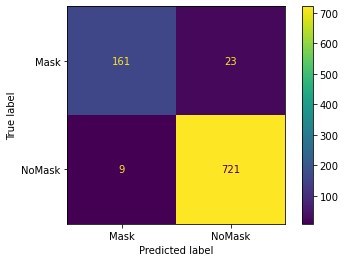

In [18]:
#plot_history(history_gray)
plot_reports(model_gray, test_data_gen_gray)

In [259]:
#model_gray.save('saveld_models/model_gray')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model_gray\assets


# Test

In [56]:
model = tensorflow.keras.models.load_model('saved_models/teachableMachines/keras_model.h5')

In [116]:
import tensorflow.keras
from PIL import Image, ImageOps
import numpy as np

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)



# Create the array of the right shape to feed into the keras model
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1.
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

# Replace this with the path to your image

path="./data/Mask_Dataset_v1/Mask_Datasets/Train/Mask/34.png"


path="./tmp/TestBild23.png"


path="./tmp/001.png"

image = Image.open(path)

#resize the image to a 224x224 with the same strategy as in TM2:
#resizing the image to be at least 224x224 and then cropping from the center
size = (224, 224)
image = ImageOps.fit(image, size, Image.ANTIALIAS)

#turn the image into a numpy array
image_array = np.asarray(image)

# display the resized image
#image.show()

# Normalize the image
normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1

# Load the image into the array
data[0] = normalized_image_array[:,:,0:3]
# run the inference
prediction = model.predict(data)
print(prediction)

[[0.9993426  0.00065734]]


Classification Report
              precision    recall  f1-score   support

        Mask       0.01      0.01      0.01       205
      NoMask       0.73      0.76      0.74       709

    accuracy                           0.59       914
   macro avg       0.37      0.39      0.38       914
weighted avg       0.57      0.59      0.58       914

Confusion Matrix


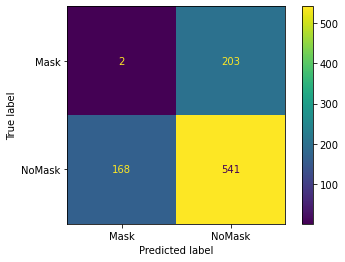

In [58]:
plot_reports(model, test_data_gen)

In [130]:
model.layers